In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load updated datasets
file_paths = {
    "fiscal_data": "C:\\Users\\zecil\\Downloads\\Fiscal Information for National Profile 122021.xlsx",
    "hospital_data": "C:\\Users\\zecil\\Downloads\\2019-2020-homeless-hospital-encounters-age-race-sex-expected-payer-by-facility.csv",
    "ca_demo_data": "C:\\Users\\zecil\\Downloads\\California_Homelessness_Demographics.xlsx"
}

# Load Fiscal Funding dataset
fiscal_data = pd.read_excel(file_paths["fiscal_data"], sheet_name=0)

# Load Hospital Encounters dataset
hospital_data = pd.read_csv(file_paths["hospital_data"])

# Load California Homelessness Demographics dataset
ca_demo_data = pd.read_excel(file_paths["ca_demo_data"])


In [2]:
# Make an explicit copy to avoid SettingWithCopyWarning
fiscal_data_cleaned = fiscal_data.dropna(subset=["State or Other Area"]).copy()

# Replace NaNs with 0 safely
fiscal_data_cleaned = fiscal_data_cleaned.fillna(0)

# Convert funding columns to numeric
funding_cols = ["2015 Actual", "2016 Actual", "2017 Actual", "2018 Actual", "2019 Actual", "2020 Actual"]
fiscal_data_cleaned[funding_cols] = fiscal_data_cleaned[funding_cols].apply(pd.to_numeric, errors='coerce')

# Feature engineering (using .loc to avoid chained assignment warnings)
fiscal_data_cleaned.loc[:, "Funding Change"] = fiscal_data_cleaned["2020 Actual"] - fiscal_data_cleaned["2015 Actual"]
fiscal_data_cleaned.loc[:, "Funding Change Rate"] = fiscal_data_cleaned["2020 Actual"].pct_change()
fiscal_data_cleaned.loc[:, "Funding Per Capita"] = fiscal_data_cleaned["2020 Actual"] / fiscal_data_cleaned["2019 Actual"]

# Final cleanup: remove infinities and fill remaining NaNs
fiscal_data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
fiscal_data_cleaned.fillna(0, inplace=True)


In [3]:
fiscal_data_cleaned.head(10)

,State or Other Area,2015 Actual,2016 Actual,2017 Actual,2018 Actual,2019 Actual,2020 Actual,Funding Change,Funding Change Rate,Funding Per Capita
0,Alabama,980926.0,1097307.0,1226417.0,1318692.0,1492007.0,1636580.0,655654.0,0.000000,1.096898
1,Alaska,164770.0,192491.0,207680.0,231620.0,264025.0,290704.0,125934.0,-0.822371,1.101047
2,Arizona,1416334.0,1519858.0,1701414.0,1903346.0,1907837.0,2091980.0,675646.0,6.196255,1.096519
3,Arkansas,669001.0,711661.0,788813.0,825329.0,885510.0,1015036.0,346035.0,-0.514797,1.146273
4,California,7540970.0,8176567.0,9004642.0,10563703.0,11328385.0,12204082.0,4663112.0,11.023300,1.077301
5,Colorado,658229.0,696654.0,739995.0,815878.0,832085.0,944685.0,286456.0,-0.922593,1.135323
6,Connecticut,514685.0,573359.0,639329.0,650436.0,763843.0,896000.0,381315.0,-0.051536,1.173016
7,Delaware,195641.0,218903.0,249625.0,270919.0,298986.0,332869.0,137228.0,-0.628494,1.113326
8,District of Columbia,189746.0,205265.0,234104.0,274538.0,288760.0,313082.0,123336.0,-0.059444,1.084229
9,Florida,3505038.0,3805384.0,4246399.0,4581364.0,5296932.0,5702319.0,2197281.0,17.213500,1.076532


In [4]:
# Clean and preprocess hospital data
hospital_data_cleaned = hospital_data.dropna(subset=["FacilityName", "HospitalCounty"])  # Drop rows with missing location

# Convert encounter values to numeric
hospital_data_cleaned["Encounters"] = pd.to_numeric(hospital_data_cleaned["Encounters"], errors="coerce")
hospital_data_cleaned["TotalEncounters"] = pd.to_numeric(hospital_data_cleaned["TotalEncounters"], errors="coerce")

# Encode categorical ownership
hospital_data_cleaned["Ownership_Public"] = (hospital_data_cleaned["Ownership"] == "Government").astype(int)
hospital_data_cleaned["Ownership_Private"] = (hospital_data_cleaned["Ownership"] == "Private").astype(int)
hospital_data_cleaned["Ownership_NonProfit"] = (hospital_data_cleaned["Ownership"] == "Non-Profit").astype(int)

# Encode shortage areas as binary
hospital_data_cleaned["PrimaryCare_Shortage"] = (hospital_data_cleaned["PrimaryCareShortageArea"] == "Yes").astype(int)
hospital_data_cleaned["MentalHealth_Shortage"] = (hospital_data_cleaned["MentalHealthShortageArea"] == "Yes").astype(int)

# Drop remaining rows with nulls in critical columns
hospital_data_cleaned.dropna(subset=["Encounters", "TotalEncounters"], inplace=True)


In [5]:
hospital_data_cleaned.head(10)

,EncounterType,HospitalCounty,OSHPD_ID,FacilityName,System,Ownership,Urban_Rural,Teaching,LicensedBedSize,PrimaryCareShortageArea,...,Demographic,DemographicValue,Encounters,TotalEncounters,Percent,Ownership_Public,Ownership_Private,Ownership_NonProfit,PrimaryCare_Shortage,MentalHealth_Shortage
0,Inpatient Hospitalizations,Alameda,10735,Alameda Hospital,Alameda Health System,Government,Urban,Non-Teaching,100-199,No,...,Age,0 to 18,0,288,0.0,1,0,0,0,0
1,Inpatient Hospitalizations,Alameda,10735,Alameda Hospital,Alameda Health System,Government,Urban,Non-Teaching,100-199,No,...,Age,19 to 39,42,288,14.6,1,0,0,0,0
2,Inpatient Hospitalizations,Alameda,10735,Alameda Hospital,Alameda Health System,Government,Urban,Non-Teaching,100-199,No,...,Age,40 to 59,147,288,51.0,1,0,0,0,0
3,Inpatient Hospitalizations,Alameda,10735,Alameda Hospital,Alameda Health System,Government,Urban,Non-Teaching,100-199,No,...,Age,60+,99,288,34.4,1,0,0,0,0
4,Inpatient Hospitalizations,Alameda,10739,Alta Bates Summit Medical Center-Alta Bates Ca...,Sutter Health,Non-Profit,Urban,Non-Teaching,300-399,No,...,Age,0 to 18,5,846,0.6,0,0,1,0,0
5,Inpatient Hospitalizations,Alameda,10739,Alta Bates Summit Medical Center-Alta Bates Ca...,Sutter Health,Non-Profit,Urban,Non-Teaching,300-399,No,...,Age,19 to 39,231,846,27.3,0,0,1,0,0
6,Inpatient Hospitalizations,Alameda,10739,Alta Bates Summit Medical Center-Alta Bates Ca...,Sutter Health,Non-Profit,Urban,Non-Teaching,300-399,No,...,Age,40 to 59,379,846,44.8,0,0,1,0,0
7,Inpatient Hospitalizations,Alameda,10739,Alta Bates Summit Medical Center-Alta Bates Ca...,Sutter Health,Non-Profit,Urban,Non-Teaching,300-399,No,...,Age,60+,231,846,27.3,0,0,1,0,0
8,Inpatient Hospitalizations,Alameda,10776,UCSF Benioff Children's Hospital Oakland,NaN,Non-Profit,Urban,Teaching,200-299,No,...,Age,0 to 18,58,63,92.1,0,0,1,0,0
9,Inpatient Hospitalizations,Alameda,10776,UCSF Benioff Children's Hospital Oakland,NaN,Non-Profit,Urban,Teaching,200-299,No,...,Age,19 to 39,5,63,7.9,0,0,1,0,0


In [6]:
# Step 1: Standardize column names for consistency
ca_demo_data.columns = ca_demo_data.columns.str.strip().str.replace(" ", "_").str.upper()

# Step 2: Rename 'YEAR' to 'CALENDAR_YEAR' for clarity
ca_demo_data.rename(columns={"YEAR": "CALENDAR_YEAR"}, inplace=True)

# Step 3: Drop rows with missing year or location
california_data_cleaned = ca_demo_data.dropna(subset=["CALENDAR_YEAR", "LOCATION"])

# Step 4: Convert Calendar Year to integer
california_data_cleaned["CALENDAR_YEAR"] = california_data_cleaned["CALENDAR_YEAR"].astype(int)

# Step 5: Convert all other demographic columns to numeric (handle non-numeric gracefully)
non_demo_cols = ["CALENDAR_YEAR", "LOCATION", "LOCATION_ID"]
demo_cols = [col for col in california_data_cleaned.columns if col not in non_demo_cols]
california_data_cleaned[demo_cols] = california_data_cleaned[demo_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Step 6: Preview cleaned dataset
california_data_cleaned.head(10)


,CALENDAR_YEAR,LOCATION_ID,LOCATION,18-24,25-34,35-44,45-54,55-64,65+,INVALID,...,QUESTIONING,TRANSGENDER,UNKNOWN_Y,"AMERICAN_INDIAN,_ALASKA_NATIVE,_OR_INDIGENOUS",ASIAN_OR_ASIAN_AMERICAN,"BLACK,_AFRICAN_AMERICAN_OR_AFRICAN",HISPANIC/LATINA/E/O,MIDDLE_EASTERN_OR_NORTH_AFRICAN,NATIVE_HAWAIIAN_OR_PACIFIC_ISLANDER,WHITE
0,2017,All,California,162750,277850,250060,266690,232390,75050,950,...,0,7080,0,92290,42720,609470,594760,0,37600,1034840
1,2017,CA-500,Santa Clara,7750,15010,14360,16350,14970,4920,0,...,0,420,0,9560,5110,17330,47760,0,3540,65530
2,2017,CA-501,San Francisco,5460,4800,4950,5990,5180,1950,0,...,0,540,0,3680,2330,18330,11950,0,1610,15630
3,2017,CA-502,Alameda,8600,9510,7590,9250,9150,3120,0,...,0,170,0,4640,2930,40770,12740,0,2240,20930
4,2017,CA-503,Sacramento,9490,16710,15000,16480,12280,3220,0,...,0,340,0,6250,2330,56310,19380,0,2840,53470
5,2017,CA-504,Sonoma,2730,4300,4400,4760,4650,1520,0,...,0,150,0,5050,580,2860,8040,0,720,22480
6,2017,CA-505,Contra Costa,3510,6850,6940,6890,6550,2460,0,...,0,0,0,3610,870,16630,7280,0,1260,15740
7,2017,CA-506,"Monterey, San Benito Counties",1810,3640,2540,2490,2450,1040,0,...,0,0,0,1140,780,2950,13710,0,600,18700
8,2017,CA-507,Marin,1030,2540,2670,3030,2870,1120,0,...,0,0,0,570,320,3770,3550,0,290,11130
9,2017,CA-508,Santa Cruz,1060,2850,2610,3160,2880,1260,0,...,0,0,0,2580,330,1370,6620,0,210,14150


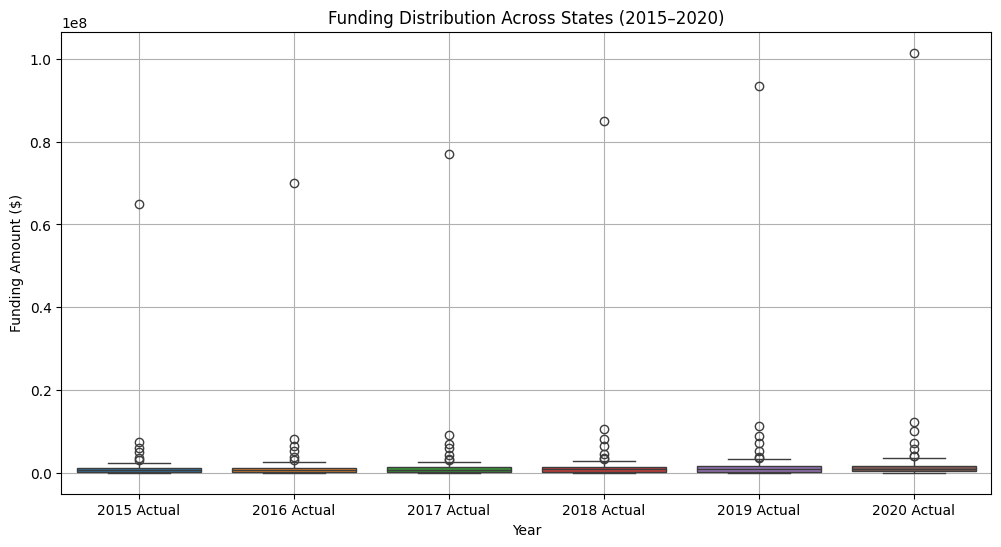

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

funding_cols = ["2015 Actual", "2016 Actual", "2017 Actual", "2018 Actual", "2019 Actual", "2020 Actual"]

plt.figure(figsize=(12, 6))
sns.boxplot(data=fiscal_data_cleaned[funding_cols])
plt.title("Funding Distribution Across States (2015–2020)")
plt.xlabel("Year")
plt.ylabel("Funding Amount ($)")
plt.grid(True)
plt.show()


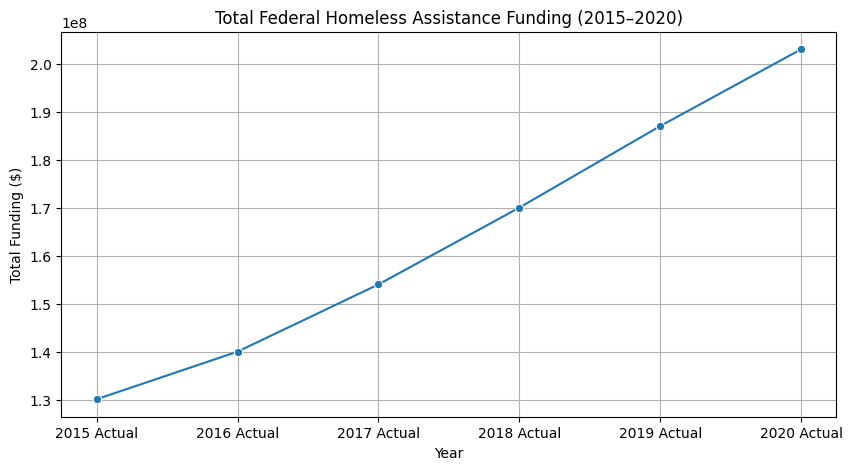

In [8]:
total_funding_by_year = fiscal_data_cleaned[funding_cols].sum()

plt.figure(figsize=(10, 5))
sns.lineplot(x=total_funding_by_year.index, y=total_funding_by_year.values, marker='o')
plt.title("Total Federal Homeless Assistance Funding (2015–2020)")
plt.xlabel("Year")
plt.ylabel("Total Funding ($)")
plt.grid(True)
plt.show()


C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\3051275713.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_change_states.head(15), x="Funding Change", y="State or Other Area", palette="viridis")


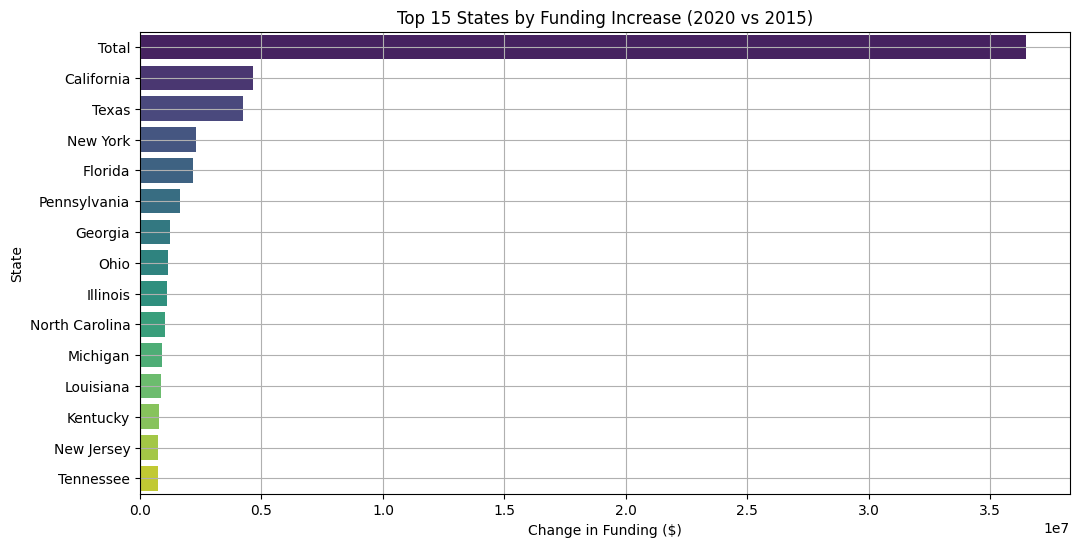

In [9]:
fiscal_data_cleaned["Funding Change"] = fiscal_data_cleaned["2020 Actual"] - fiscal_data_cleaned["2015 Actual"]

top_change_states = fiscal_data_cleaned[["State or Other Area", "Funding Change"]].sort_values(by="Funding Change", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_change_states.head(15), x="Funding Change", y="State or Other Area", palette="viridis")
plt.title("Top 15 States by Funding Increase (2020 vs 2015)")
plt.xlabel("Change in Funding ($)")
plt.ylabel("State")
plt.grid(True)
plt.show()


C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\128901548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hospital_summary, x="DemographicValue", y="Encounters", palette="coolwarm")


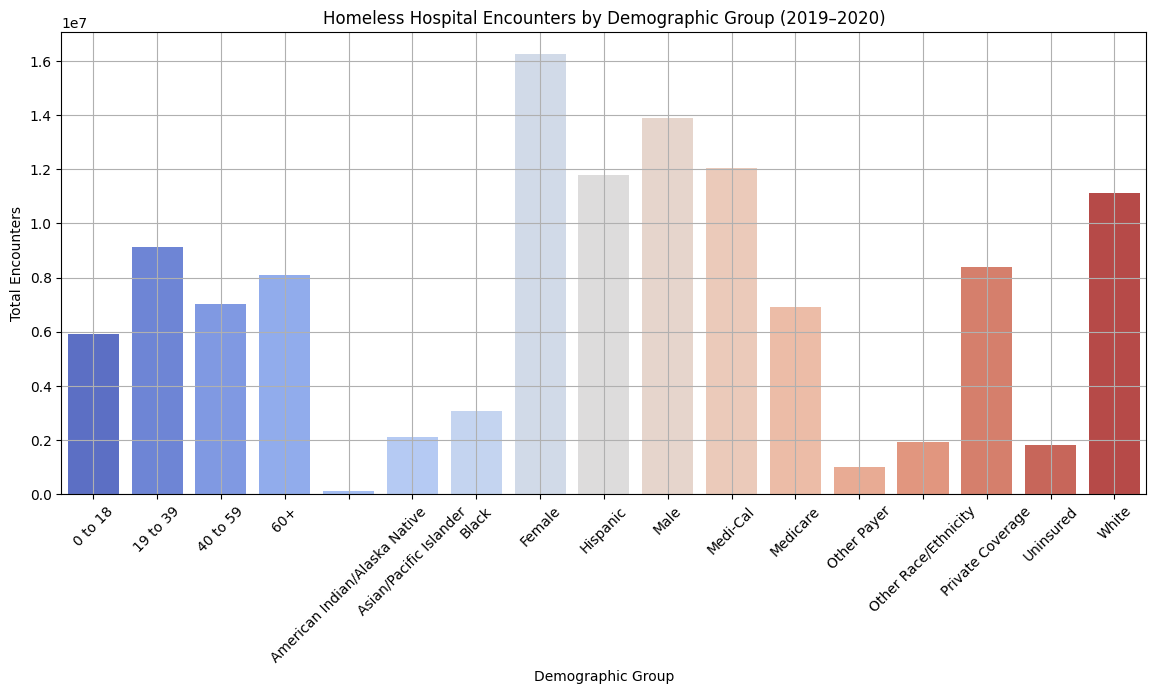

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by demographic value and sum encounters
hospital_summary = hospital_data_cleaned.groupby("DemographicValue")["Encounters"].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=hospital_summary, x="DemographicValue", y="Encounters", palette="coolwarm")
plt.title("Homeless Hospital Encounters by Demographic Group (2019–2020)")
plt.xlabel("Demographic Group")
plt.ylabel("Total Encounters")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\3379801608.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_summary, x="DemographicValue", y="Encounters", palette="Blues_r")


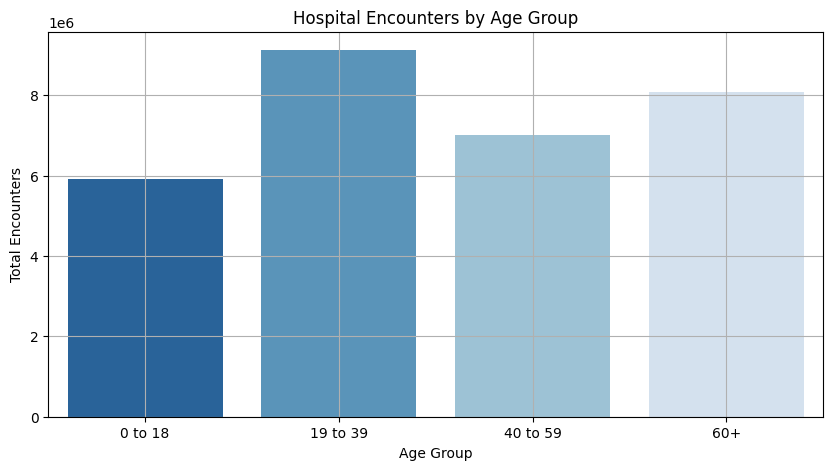

In [11]:
# Filter for age-related groups using known labels
age_keywords = ["0 to 18", "19 to 39", "40 to 59", "60+"]
age_data = hospital_data_cleaned[hospital_data_cleaned["DemographicValue"].isin(age_keywords)]

age_summary = age_data.groupby("DemographicValue")["Encounters"].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=age_summary, x="DemographicValue", y="Encounters", palette="Blues_r")
plt.title("Hospital Encounters by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Total Encounters")
plt.grid(True)
plt.show()


C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\991145728.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sex_summary, x="DemographicValue", y="Encounters", palette="Greys")


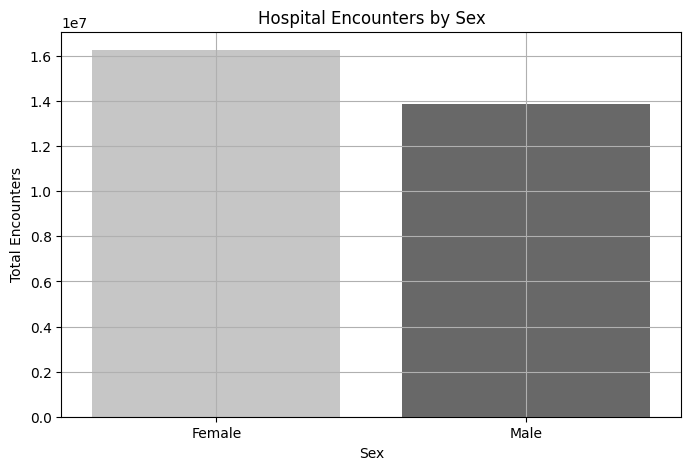

In [12]:
sex_keywords = ["Male", "Female"]
sex_data = hospital_data_cleaned[hospital_data_cleaned["DemographicValue"].isin(sex_keywords)]

sex_summary = sex_data.groupby("DemographicValue")["Encounters"].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=sex_summary, x="DemographicValue", y="Encounters", palette="Greys")
plt.title("Hospital Encounters by Sex")
plt.xlabel("Sex")
plt.ylabel("Total Encounters")
plt.grid(True)
plt.show()


C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\8969870.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=race_summary, x="DemographicValue", y="Encounters", palette="Oranges_r")


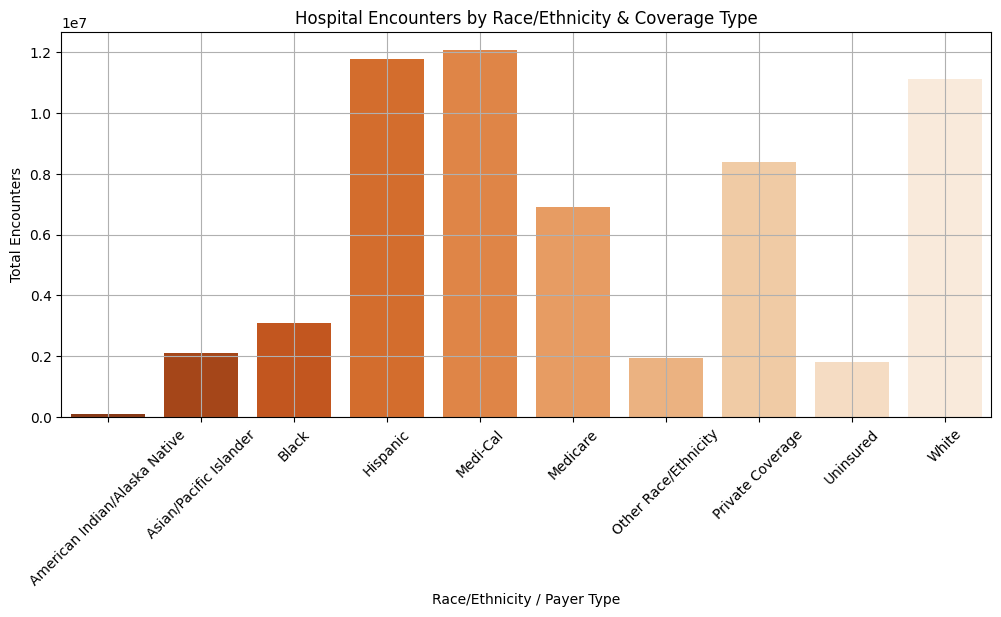

In [13]:
race_keywords = [
    "White", "Black", "Asian/Pacific Islander", "American Indian/Alaska Native",
    "Other Race/Ethnicity", "Hispanic", "Uninsured", "Private Coverage", "Medicare", "Medi-Cal"
]
race_data = hospital_data_cleaned[hospital_data_cleaned["DemographicValue"].isin(race_keywords)]

race_summary = race_data.groupby("DemographicValue")["Encounters"].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(data=race_summary, x="DemographicValue", y="Encounters", palette="Oranges_r")
plt.title("Hospital Encounters by Race/Ethnicity & Coverage Type")
plt.xlabel("Race/Ethnicity / Payer Type")
plt.ylabel("Total Encounters")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\491838122.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payer_summary, x="DemographicValue", y="Encounters", palette="Purples_r")


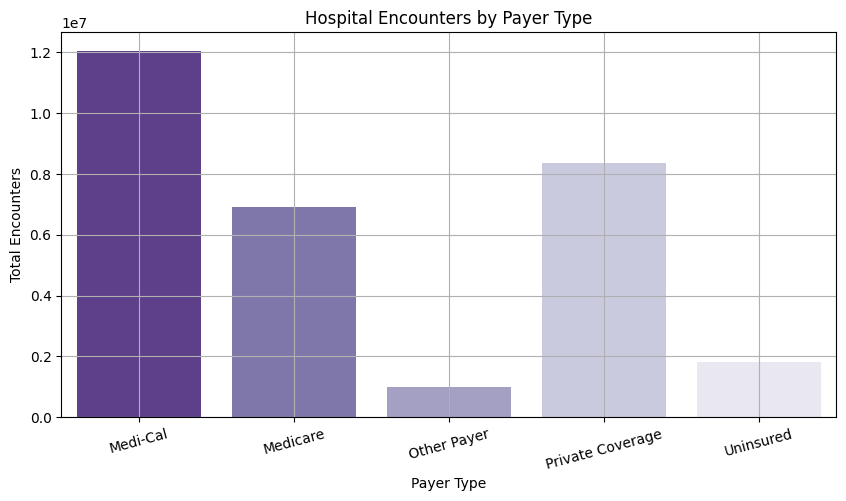

In [14]:
# Define known payer types from the dataset
payer_keywords = [
    "Medi-Cal", "Medicare", "Private Coverage", "Uninsured", "Other Payer"
]

# Filter data for payer types only
payer_data = hospital_data_cleaned[hospital_data_cleaned["DemographicValue"].isin(payer_keywords)]

# Summarize total encounters per payer type
payer_summary = payer_data.groupby("DemographicValue")["Encounters"].sum().reset_index()

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(data=payer_summary, x="DemographicValue", y="Encounters", palette="Purples_r")
plt.title("Hospital Encounters by Payer Type")
plt.xlabel("Payer Type")
plt.ylabel("Total Encounters")
plt.xticks(rotation=15)
plt.grid(True)
plt.show()


In [15]:
# Create a helper column to group demographics into categories
def label_category(value):
    if value in ["0 to 18", "19 to 39", "40 to 59", "60+"]:
        return "Age"
    elif value in ["Male", "Female"]:
        return "Sex"
    elif value in ["White", "Black", "Asian/Pacific Islander", "American Indian/Alaska Native", "Other Race/Ethnicity", "Hispanic"]:
        return "Race/Ethnicity"
    elif value in ["Medi-Cal", "Medicare", "Private Coverage", "Uninsured", "Other Payer"]:
        return "Payer"
    else:
        return "Unknown"

hospital_data_cleaned["DemographicCategory"] = hospital_data_cleaned["DemographicValue"].apply(label_category)


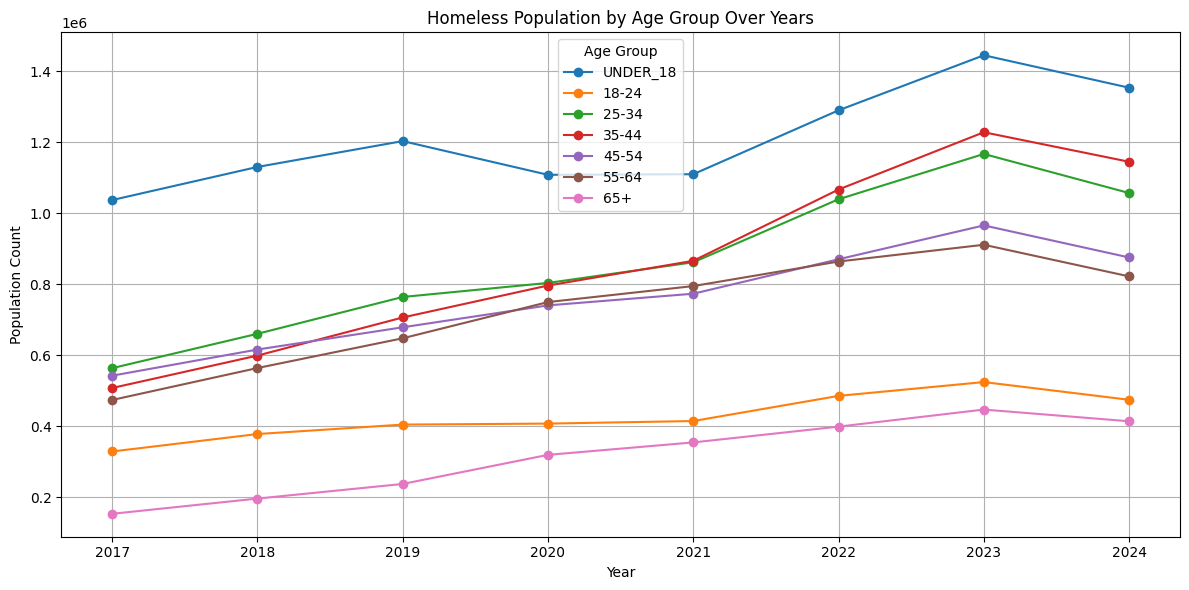

In [16]:
# Age group columns
age_columns = ['UNDER_18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Summing age groups by year
age_summary = california_data_cleaned.groupby('CALENDAR_YEAR')[age_columns].sum()

# Plotting age group trends
plt.figure(figsize=(12, 6))
for col in age_columns:
    plt.plot(age_summary.index, age_summary[col], marker='o', label=col)

plt.title("Homeless Population by Age Group Over Years")
plt.xlabel("Year")
plt.ylabel("Population Count")
plt.legend(title="Age Group")
plt.grid(True)
plt.tight_layout()
plt.show()


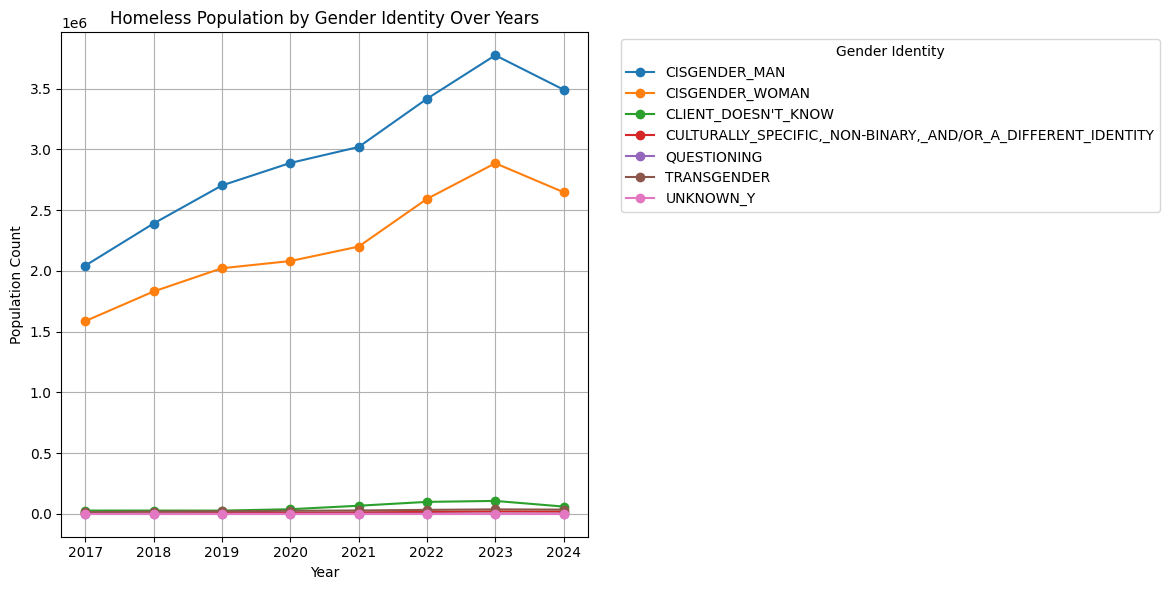

In [17]:
# Gender identity columns
gender_columns = [
    'CISGENDER_MAN', 'CISGENDER_WOMAN', "CLIENT_DOESN'T_KNOW",
    'CULTURALLY_SPECIFIC,_NON-BINARY,_AND/OR_A_DIFFERENT_IDENTITY',
    'QUESTIONING', 'TRANSGENDER', 'UNKNOWN_Y'
]

# Summing gender groups by year
gender_summary = california_data_cleaned.groupby('CALENDAR_YEAR')[gender_columns].sum()

# Plotting gender identity trends
plt.figure(figsize=(12, 6))
for col in gender_columns:
    plt.plot(gender_summary.index, gender_summary[col], marker='o', label=col)

plt.title("Homeless Population by Gender Identity Over Years")
plt.xlabel("Year")
plt.ylabel("Population Count")
plt.legend(title="Gender Identity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


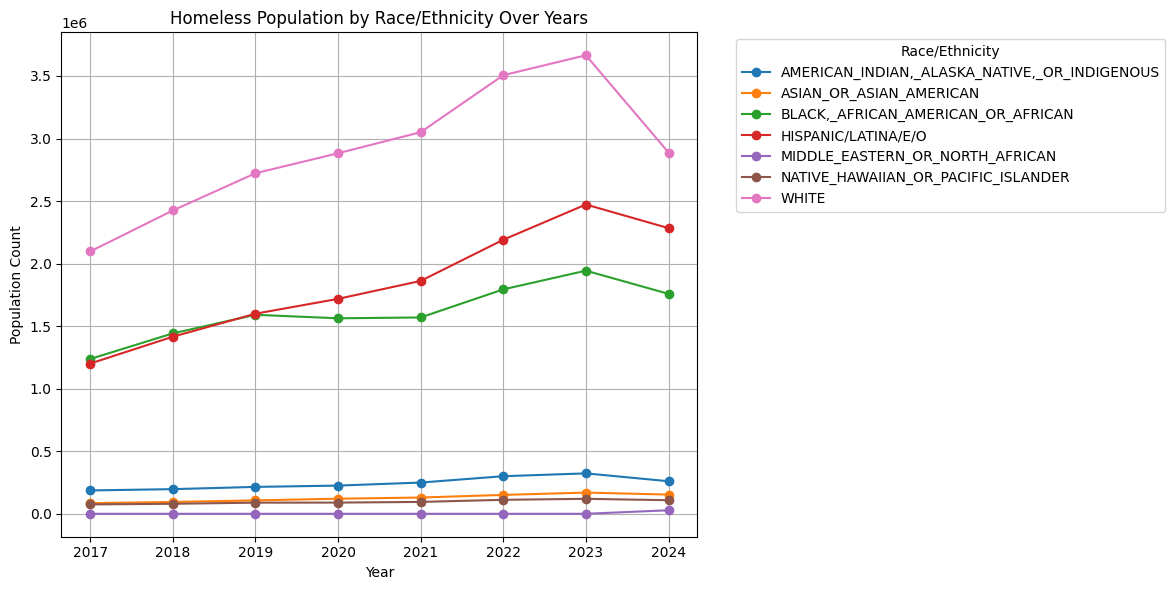

In [18]:
# Race/ethnicity columns
race_columns = [
    'AMERICAN_INDIAN,_ALASKA_NATIVE,_OR_INDIGENOUS', 'ASIAN_OR_ASIAN_AMERICAN',
    'BLACK,_AFRICAN_AMERICAN_OR_AFRICAN', 'HISPANIC/LATINA/E/O',
    'MIDDLE_EASTERN_OR_NORTH_AFRICAN', 'NATIVE_HAWAIIAN_OR_PACIFIC_ISLANDER', 'WHITE'
]

# Summing race groups by year
race_summary = california_data_cleaned.groupby('CALENDAR_YEAR')[race_columns].sum()

# Plotting race/ethnicity trends
plt.figure(figsize=(12, 6))
for col in race_columns:
    plt.plot(race_summary.index, race_summary[col], marker='o', label=col)

plt.title("Homeless Population by Race/Ethnicity Over Years")
plt.xlabel("Year")
plt.ylabel("Population Count")
plt.legend(title="Race/Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Select features (past funding years) and target (2020 funding)
fiscal_features = ["2015 Actual", "2016 Actual", "2017 Actual", "2018 Actual", "2019 Actual"]
fiscal_target = "2020 Actual"

X_fiscal = fiscal_data_cleaned[fiscal_features]
y_fiscal = fiscal_data_cleaned[fiscal_target]

# Train-test split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_fiscal, y_fiscal, test_size=0.2, random_state=42)

# Fit baseline model
model_fiscal = LinearRegression()
model_fiscal.fit(X_train_f, y_train_f)
y_pred_f = model_fiscal.predict(X_test_f)

# Evaluate
# Evaluate
mae_f = mean_absolute_error(y_test_f, y_pred_f)
rmse_f = mean_squared_error(y_test_f, y_pred_f) ** 0.5

print(f"Fiscal Model - MAE: {mae_f:.2f}, RMSE: {rmse_f:.2f}")


Fiscal Model - MAE: 33617.86, RMSE: 58663.42


In [20]:
# Simple model: Predict total encounters from specific 'Encounters' value
X_hosp = hospital_data_cleaned[["Encounters"]]
y_hosp = hospital_data_cleaned["TotalEncounters"]

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hosp, y_hosp, test_size=0.2, random_state=42)

model_hospital = LinearRegression()
model_hospital.fit(X_train_h, y_train_h)
y_pred_h = model_hospital.predict(X_test_h)

mae_h = mean_absolute_error(y_test_h, y_pred_h)
rmse_h = mean_squared_error(y_test_h, y_pred_h) ** 0.5

print(f"Hospital Model - MAE: {mae_h:.2f}, RMSE: {rmse_h:.2f}")


Hospital Model - MAE: 15354.44, RMSE: 25844.78


In [21]:
# Generate total homeless population by summing across all demographic groups
homeless_demo_cols = [col for col in california_data_cleaned.columns if col not in ["CALENDAR_YEAR", "LOCATION", "LOCATION_ID"]]
california_data_cleaned["TOTAL_HOMELESS"] = california_data_cleaned[homeless_demo_cols].sum(axis=1)

# Predict homelessness based on year
X_demo = california_data_cleaned[["CALENDAR_YEAR"]]
y_demo = california_data_cleaned["TOTAL_HOMELESS"]

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_demo, y_demo, test_size=0.2, random_state=42)

model_demo = LinearRegression()
model_demo.fit(X_train_d, y_train_d)
y_pred_d = model_demo.predict(X_test_d)

mae_d = mean_absolute_error(y_test_d, y_pred_d)
rmse_d = mean_squared_error(y_test_d, y_pred_d) ** 0.5

print(f"CA Homelessness Model - MAE: {mae_d:.2f}, RMSE: {rmse_d:.2f}")


CA Homelessness Model - MAE: 636660.03, RMSE: 1651356.48


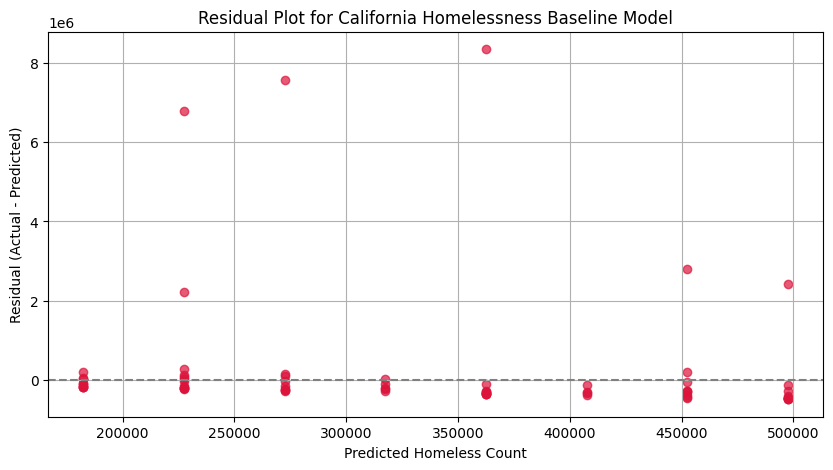

In [22]:
import matplotlib.pyplot as plt

# Calculate residuals for CA Homelessness model
residuals_demo = y_test_d - y_pred_d

# Plot residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_d, residuals_demo, color='crimson', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Predicted Homeless Count")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot for California Homelessness Baseline Model")
plt.grid(True)
plt.show()


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load cleaned fiscal dataset
fiscal_data_cleaned = fiscal_data.dropna(subset=["State or Other Area"]).copy()
fiscal_data_cleaned = fiscal_data_cleaned.fillna(0)

funding_cols = ["2015 Actual", "2016 Actual", "2017 Actual", "2018 Actual", "2019 Actual", "2020 Actual"]
fiscal_data_cleaned[funding_cols] = fiscal_data_cleaned[funding_cols].apply(pd.to_numeric, errors='coerce')

# Features and target
X_fiscal = fiscal_data_cleaned[["2015 Actual", "2016 Actual", "2017 Actual", "2018 Actual", "2019 Actual"]]
y_fiscal = fiscal_data_cleaned["2020 Actual"]

# Train-test split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_fiscal, y_fiscal, test_size=0.2, random_state=42)

# Train Random Forest
rf_model_f = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_f.fit(X_train_f, y_train_f)
rf_preds = rf_model_f.predict(X_test_f)

# Train Gradient Boosting
gb_model_f = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, random_state=42)
gb_model_f.fit(X_train_f, y_train_f)
gb_preds = gb_model_f.predict(X_test_f)

# Evaluation
rf_mae = mean_absolute_error(y_test_f, rf_preds)
rf_rmse = mean_squared_error(y_test_f, rf_preds) ** 0.5

gb_mae = mean_absolute_error(y_test_f, gb_preds)
gb_rmse = mean_squared_error(y_test_f, gb_preds) ** 0.5

print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}")
print(f"Gradient Boosting - MAE: {gb_mae:.2f}, RMSE: {gb_rmse:.2f}")

# Feature Importances from Gradient Boosting
feature_importance = pd.DataFrame({
    "Feature": X_fiscal.columns,
    "Importance": gb_model_f.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importances (Gradient Boosting):")
print(feature_importance)


Random Forest - MAE: 174493.09, RMSE: 435044.13
Gradient Boosting - MAE: 163938.61, RMSE: 448733.44

Feature Importances (Gradient Boosting):
       Feature  Importance
3  2018 Actual    0.538927
4  2019 Actual    0.248890
0  2015 Actual    0.098907
1  2016 Actual    0.086536
2  2017 Actual    0.026741


In [24]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define features and target
X_hosp = hospital_data_cleaned[["Encounters", "Ownership_Public", "Ownership_Private", "Ownership_NonProfit",
                                "PrimaryCare_Shortage", "MentalHealth_Shortage"]]
y_hosp = hospital_data_cleaned["TotalEncounters"]

# Split data
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hosp, y_hosp, test_size=0.2, random_state=42)

# Train Random Forest
rf_model_h = RandomForestRegressor(random_state=42)
rf_model_h.fit(X_train_h, y_train_h)
rf_preds_h = rf_model_h.predict(X_test_h)

# Train Gradient Boosting
gb_model_h = GradientBoostingRegressor(random_state=42)
gb_model_h.fit(X_train_h, y_train_h)
gb_preds_h = gb_model_h.predict(X_test_h)

# Evaluation
rf_mae_h = mean_absolute_error(y_test_h, rf_preds_h)
rf_rmse_h = mean_squared_error(y_test_h, rf_preds_h) ** 0.5

gb_mae_h = mean_absolute_error(y_test_h, gb_preds_h)
gb_rmse_h = mean_squared_error(y_test_h, gb_preds_h) ** 0.5

print("🏥 Hospital Dataset Results:")
print(f"Random Forest - MAE: {rf_mae_h:.2f}, RMSE: {rf_rmse_h:.2f}")
print(f"Gradient Boosting - MAE: {gb_mae_h:.2f}, RMSE: {gb_rmse_h:.2f}")

🏥 Hospital Dataset Results:
Random Forest - MAE: 13684.51, RMSE: 26379.29
Gradient Boosting - MAE: 12575.64, RMSE: 23653.26


In [25]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Use all demographic columns as features
demo_cols = [col for col in california_data_cleaned.columns if col not in ["CALENDAR_YEAR", "LOCATION", "LOCATION_ID", "TOTAL_HOMELESS"]]

# Step 2: Target is TOTAL_HOMELESS (already computed earlier)
X_demo = california_data_cleaned[demo_cols]
y_demo = california_data_cleaned["TOTAL_HOMELESS"]

# Step 3: Split data
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_demo, y_demo, test_size=0.2, random_state=42)

# Step 4: Train models
rf_model_d = RandomForestRegressor(random_state=42)
rf_model_d.fit(X_train_d, y_train_d)
rf_preds_d = rf_model_d.predict(X_test_d)

gb_model_d = GradientBoostingRegressor(random_state=42)
gb_model_d.fit(X_train_d, y_train_d)
gb_preds_d = gb_model_d.predict(X_test_d)

# Step 5: Evaluation
rf_mae_d = mean_absolute_error(y_test_d, rf_preds_d)
rf_rmse_d = mean_squared_error(y_test_d, rf_preds_d) ** 0.5

gb_mae_d = mean_absolute_error(y_test_d, gb_preds_d)
gb_rmse_d = mean_squared_error(y_test_d, gb_preds_d) ** 0.5

print("🏠 California Homelessness Dataset Results:")
print(f"Random Forest - MAE: {rf_mae_d:.2f}, RMSE: {rf_rmse_d:.2f}")
print(f"Gradient Boosting - MAE: {gb_mae_d:.2f}, RMSE: {gb_rmse_d:.2f}")


🏠 California Homelessness Dataset Results:
Random Forest - MAE: 15328.78, RMSE: 41790.96
Gradient Boosting - MAE: 51401.37, RMSE: 194341.18


In [26]:
# --------- STEP 1: Feature Engineering ---------
fiscal_data_fe = fiscal_data_cleaned.copy()

# Year-over-Year (YOY) changes
for i in range(2016, 2021):
    fiscal_data_fe[f"YOY_{i}"] = fiscal_data_fe[f"{i} Actual"] - fiscal_data_fe[f"{i-1} Actual"]

# 3-year Moving Average (2018–2020)
fiscal_data_fe["3yr_MA"] = fiscal_data_fe[["2018 Actual", "2019 Actual", "2020 Actual"]].mean(axis=1)

# Log transform target variable
fiscal_data_fe["Log_2020"] = np.log1p(fiscal_data_fe["2020 Actual"])

# Volatility (Standard Deviation) across funding years
funding_cols = ["2015 Actual", "2016 Actual", "2017 Actual", "2018 Actual", "2019 Actual", "2020 Actual"]
fiscal_data_fe["Funding_Volatility"] = fiscal_data_fe[funding_cols].std(axis=1)

# Drop rows with any remaining NaNs
fiscal_data_fe.dropna(inplace=True)

# --------- STEP 2: Modeling ---------
# Features for prediction
features = ["2015 Actual", "2016 Actual", "2017 Actual", "2018 Actual", "2019 Actual",
            "YOY_2016", "YOY_2017", "YOY_2018", "YOY_2019", "YOY_2020",
            "3yr_MA", "Funding_Volatility"]
target = "Log_2020"

X_f = fiscal_data_fe[features]
y_f = fiscal_data_fe[target]

# Train-Test Split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, random_state=42)

# --------- STEP 3: Train Models ---------
rf_model_f = RandomForestRegressor(n_estimators=200, random_state=42)
gb_model_f = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)

rf_model_f.fit(X_train_f, y_train_f)
gb_model_f.fit(X_train_f, y_train_f)

# --------- STEP 4: Predictions ---------
rf_preds = np.expm1(rf_model_f.predict(X_test_f))
gb_preds = np.expm1(gb_model_f.predict(X_test_f))
y_true = np.expm1(y_test_f)

# --------- STEP 5: Evaluation ---------
rf_mae = mean_absolute_error(y_true, rf_preds)
rf_rmse = mean_squared_error(y_true, rf_preds) ** 0.5

gb_mae = mean_absolute_error(y_true, gb_preds)
gb_rmse = mean_squared_error(y_true, gb_preds) ** 0.5

print("📊 Reengineered Fiscal Model Performance:")
print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}")
print(f"Gradient Boosting - MAE: {gb_mae:.2f}, RMSE: {gb_rmse:.2f}")


📊 Reengineered Fiscal Model Performance:
Random Forest - MAE: 199183.20, RMSE: 377965.23
Gradient Boosting - MAE: 121416.47, RMSE: 226640.79


In [27]:
# Create copy
hospital_data_fe = hospital_data_cleaned.copy()

# Map LicensedBedSize ranges to midpoints
bed_size_mapping = {
    "0-99": 50, "100-199": 150, "200-299": 250, "300-399": 350, "400-499": 450,
    "500-599": 550, "600-699": 650, "700+": 750
}
hospital_data_fe["LicensedBedSize"] = hospital_data_fe["LicensedBedSize"].map(bed_size_mapping)

# Drop rows with nulls after mapping
hospital_data_fe.dropna(subset=["LicensedBedSize", "Encounters", "TotalEncounters"], inplace=True)

# Feature engineering
hospital_data_fe["Log_TotalEncounters"] = np.log1p(hospital_data_fe["TotalEncounters"])
hospital_data_fe["EncountersPerBed"] = hospital_data_fe["Encounters"] / (hospital_data_fe["LicensedBedSize"] + 1e-5)
hospital_data_fe["UrbanFlag"] = (hospital_data_fe["Urban_Rural"] == "Urban").astype(int)

# Define features and target
features_hosp = [
    "Encounters", "Ownership_Public", "Ownership_Private", "Ownership_NonProfit",
    "PrimaryCare_Shortage", "MentalHealth_Shortage", "UrbanFlag", "EncountersPerBed"
]
target_hosp = "Log_TotalEncounters"

X_h = hospital_data_fe[features_hosp]
y_h = hospital_data_fe[target_hosp]

# Split
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.2, random_state=42)

# Models
rf_model_h = RandomForestRegressor(n_estimators=200, random_state=42)
gb_model_h = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)

rf_model_h.fit(X_train_h, y_train_h)
gb_model_h.fit(X_train_h, y_train_h)

# Predictions
rf_preds_h = np.expm1(rf_model_h.predict(X_test_h))
gb_preds_h = np.expm1(gb_model_h.predict(X_test_h))
y_true_h = np.expm1(y_test_h)

# Evaluation
rf_mae_h = mean_absolute_error(y_true_h, rf_preds_h)
rf_rmse_h = mean_squared_error(y_true_h, rf_preds_h) ** 0.5
gb_mae_h = mean_absolute_error(y_true_h, gb_preds_h)
gb_rmse_h = mean_squared_error(y_true_h, gb_preds_h) ** 0.5

print("🏥 Hospital Dataset (Re-Engineered Models):")
print(f"Random Forest - MAE: {rf_mae_h:.2f}, RMSE: {rf_rmse_h:.2f}")
print(f"Gradient Boosting - MAE: {gb_mae_h:.2f}, RMSE: {gb_rmse_h:.2f}")


🏥 Hospital Dataset (Re-Engineered Models):
Random Forest - MAE: 12691.19, RMSE: 24854.55
Gradient Boosting - MAE: 11737.62, RMSE: 24115.57


In [28]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# -------- STEP 1: Feature Engineering --------
# Copy cleaned dataset
ca_data_fe = california_data_cleaned.copy()

# Total homeless already calculated, but re-confirm
demo_cols = [col for col in ca_data_fe.columns if col not in ["CALENDAR_YEAR", "LOCATION", "LOCATION_ID", "TOTAL_HOMELESS"]]
ca_data_fe["TOTAL_HOMELESS"] = ca_data_fe[demo_cols].sum(axis=1)

# Add time-based features
ca_data_fe["YEAR_DIFF"] = ca_data_fe["CALENDAR_YEAR"] - ca_data_fe["CALENDAR_YEAR"].min()
ca_data_fe["YEAR_SQ"] = ca_data_fe["YEAR_DIFF"] ** 2

# -------- STEP 2: Define Features and Target --------
features_demo = demo_cols + ["YEAR_DIFF", "YEAR_SQ"]
target_demo = "TOTAL_HOMELESS"

X_d = ca_data_fe[features_demo]
y_d = ca_data_fe[target_demo]

# -------- STEP 3: Train-Test Split --------
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=42)

# -------- STEP 4: Train Models --------
rf_model_d = RandomForestRegressor(n_estimators=200, random_state=42)
gb_model_d = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)

rf_model_d.fit(X_train_d, y_train_d)
gb_model_d.fit(X_train_d, y_train_d)

# -------- STEP 5: Predictions --------
rf_preds_d = rf_model_d.predict(X_test_d)
gb_preds_d = gb_model_d.predict(X_test_d)

# -------- STEP 6: Evaluation --------
rf_mae_d = mean_absolute_error(y_test_d, rf_preds_d)
rf_rmse_d = mean_squared_error(y_test_d, rf_preds_d) ** 0.5

gb_mae_d = mean_absolute_error(y_test_d, gb_preds_d)
gb_rmse_d = mean_squared_error(y_test_d, gb_preds_d) ** 0.5

# -------- STEP 7: Results --------
print("🏠 California Homelessness Dataset (Re-Engineered Models):")
print(f"Random Forest - MAE: {rf_mae_d:.2f}, RMSE: {rf_rmse_d:.2f}")
print(f"Gradient Boosting - MAE: {gb_mae_d:.2f}, RMSE: {gb_rmse_d:.2f}")

🏠 California Homelessness Dataset (Re-Engineered Models):
Random Forest - MAE: 12112.23, RMSE: 34998.66
Gradient Boosting - MAE: 25630.27, RMSE: 96847.80


In [29]:
# # Step 1: Prepare CA Homelessness Aggregated by County
# ca_demo_agg = california_data_cleaned.groupby("LOCATION").agg({"TOTAL_HOMELESS": "sum"}).reset_index()
# ca_demo_agg.rename(columns={"LOCATION": "County"}, inplace=True)

# # Step 2: Aggregate Hospital Data by County
# hospital_agg = hospital_data_cleaned.groupby("HospitalCounty").agg({
#     "Encounters": "sum",
#     "TotalEncounters": "sum",
#     "Ownership_Public": "mean",
#     "Ownership_Private": "mean",
#     "Ownership_NonProfit": "mean",
#     "PrimaryCare_Shortage": "mean",
#     "MentalHealth_Shortage": "mean"
# }).reset_index()
# hospital_agg.rename(columns={"HospitalCounty": "County"}, inplace=True)

# # Step 3: Extract state-level CA fiscal data and replicate it for each county
# fiscal_ca_state = fiscal_data_cleaned[fiscal_data_cleaned["State or Other Area"] == "California"].copy()
# fiscal_values = fiscal_ca_state[["2015 Actual", "2016 Actual", "2017 Actual", "2018 Actual", "2019 Actual", "2020 Actual"]].iloc[0]

# # Create a DataFrame with same counties as in CA homelessness data
# fiscal_replicated = pd.DataFrame({
#     "County": ca_demo_agg["County"]
# })
# for col in fiscal_values.index:
#     fiscal_replicated[col] = fiscal_values[col]

# # Step 4: Merge everything on County
# merged_all = fiscal_replicated.merge(hospital_agg, on="County", how="inner")
# merged_all = merged_all.merge(ca_demo_agg, on="County", how="inner")

# # Final Cleanup
# merged_all.replace([np.inf, -np.inf], np.nan, inplace=True)
# merged_all.dropna(inplace=True)

# # Preview Merged Dataset
# print("✅ Merged Dataset Shape:", merged_all.shape)
# display(merged_all)


In [30]:
# --- Step 1: Merge Hospital and Homelessness Data by County ---
# Prepare both datasets
hospital_summary = hospital_data_cleaned.groupby("HospitalCounty").agg({
    "Encounters": "sum",
    "TotalEncounters": "sum",
    "Ownership_Public": "mean",
    "Ownership_Private": "mean",
    "Ownership_NonProfit": "mean",
    "PrimaryCare_Shortage": "mean",
    "MentalHealth_Shortage": "mean"
}).reset_index().rename(columns={"HospitalCounty": "County"})

homeless_summary = california_data_cleaned.groupby("LOCATION").agg({
    "TOTAL_HOMELESS": "sum"
}).reset_index().rename(columns={"LOCATION": "County"})

# Merge hospital and homelessness datasets
merged_county_data = pd.merge(hospital_summary, homeless_summary, on="County", how="inner")

# --- Step 2: Extract Fiscal Funding Data for California Only (state-level context) ---
fiscal_state_ca = fiscal_data_cleaned[fiscal_data_cleaned["State or Other Area"] == "California"]
fiscal_summary_ca = fiscal_state_ca[["2015 Actual", "2016 Actual", "2017 Actual", "2018 Actual", "2019 Actual", "2020 Actual"]]

# Optional: Print or use as reference for funding trends (do NOT merge this with counties)
fiscal_summary_ca.reset_index(drop=True, inplace=True)

merged_county_data

,County,Encounters,TotalEncounters,Ownership_Public,Ownership_Private,Ownership_NonProfit,PrimaryCare_Shortage,MentalHealth_Shortage,TOTAL_HOMELESS
0,Alameda,5140691,21848353,0.250000,0.0,0.625000,0.062500,0.000000,2505920
1,Butte,884106,3757460,0.142857,0.0,0.857143,0.571429,1.000000,646240
2,Contra Costa,2884119,12257599,0.133333,0.0,0.733333,0.000000,0.000000,1255280
3,El Dorado,377944,1606279,0.000000,0.0,0.800000,0.400000,0.400000,108910
4,Humboldt,488612,2076617,0.333333,0.0,0.000000,1.000000,1.000000,451510
5,Imperial,693773,2948547,1.000000,0.0,0.000000,1.000000,1.000000,366740
6,Kern,3086763,13118814,0.181818,0.0,0.590909,0.409091,1.000000,1487780
7,Lake,323594,1375280,0.000000,0.0,1.000000,1.000000,1.000000,45970
8,Los Angeles,31025497,131859926,0.078212,0.0,0.488827,0.262570,0.134078,21899520
9,Marin,629440,2675151,0.000000,0.0,0.857143,0.000000,0.000000,402970


In [31]:
# --- Step 1: Prepare Feature Set and Target ---
multi_source_data = merged_county_data.copy()

# Features (excluding County and target column)
features = [col for col in multi_source_data.columns if col not in ["County", "TOTAL_HOMELESS"]]
target = "TOTAL_HOMELESS"

X = multi_source_data[features]
y = multi_source_data[target]

# --- Step 2: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Train Random Forest Model ---
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# --- Step 4: Train Gradient Boosting Model ---
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

# --- Step 5: Evaluation ---
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds) ** 0.5

gb_mae = mean_absolute_error(y_test, gb_preds)
gb_rmse = mean_squared_error(y_test, gb_preds) ** 0.5

print("Multi-Source Model Results (Hospital + Homeless):")
print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}")
print(f"Gradient Boosting - MAE: {gb_mae:.2f}, RMSE: {gb_rmse:.2f}")


Multi-Source Model Results (Hospital + Homeless):
Random Forest - MAE: 3324653.66, RMSE: 7123181.64
Gradient Boosting - MAE: 3279135.98, RMSE: 6798108.65


In [32]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- STEP 1: Prepare Features and Target ---
multi_source_data_cleaned = merged_county_data.dropna(subset=["TOTAL_HOMELESS"]).copy()

features = [
    "Encounters", "TotalEncounters", "Ownership_Public", "Ownership_Private", "Ownership_NonProfit",
    "PrimaryCare_Shortage", "MentalHealth_Shortage"
]

X = multi_source_data_cleaned[features]
y = multi_source_data_cleaned["TOTAL_HOMELESS"]

# --- STEP 2: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- STEP 3: Train XGBoost Regressor ---
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# --- STEP 4: Predict and Evaluate ---
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print("📦 XGBoost Model Performance (Multi-Source Dataset):")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# --- STEP 5: Feature Importances (Optional) ---
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 XGBoost Feature Importances:")
print(importances)


📦 XGBoost Model Performance (Multi-Source Dataset):
MAE: 3406128.50, RMSE: 7247934.79

📊 XGBoost Feature Importances:
                 Feature  Importance
0             Encounters    0.593592
6  MentalHealth_Shortage    0.162785
5   PrimaryCare_Shortage    0.154456
2       Ownership_Public    0.061260
4    Ownership_NonProfit    0.027907
1        TotalEncounters    0.000000
3      Ownership_Private    0.000000


In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

features = [
    "Encounters", "TotalEncounters", "Ownership_Public", "Ownership_Private",
    "Ownership_NonProfit", "PrimaryCare_Shortage", "MentalHealth_Shortage"
]
target = "TOTAL_HOMELESS"

X = merged_county_data[features]
y = merged_county_data[target]

# ----- Step 2: Standardize features -----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----- Step 3: Apply PCA -----
pca = PCA(n_components=0.95)  # retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# ----- Step 4: Train-test split -----
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# ----- Step 5: Model Training with Gradient Boosting -----
gbm = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gbm.fit(X_train, y_train)

# ----- Step 6: Evaluation -----
y_pred = gbm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print("\nPCA-Based Gradient Boosting Performance:")
print(f"MAE: {mae:,.2f}, RMSE: {rmse:,.2f}")

# ----- Optional: Check explained variance -----
print("\n Explained Variance by PCA Components:")
print(pca.explained_variance_ratio_)




PCA-Based Gradient Boosting Performance:
MAE: 2,961,708.52, RMSE: 6,842,054.08

 Explained Variance by PCA Components:
[0.40982136 0.30435168 0.18549268 0.06338065]


📊 Holdout Set - MAE: 3,811,513.68, RMSE: 7,570,035.84


C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\255390970.py:56: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\zecil\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


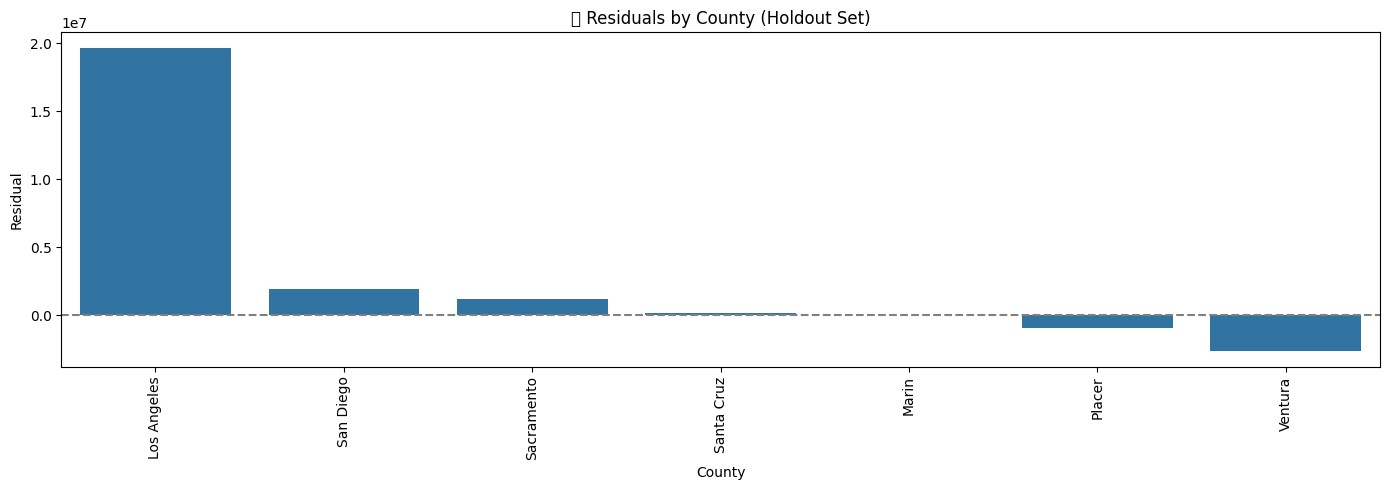

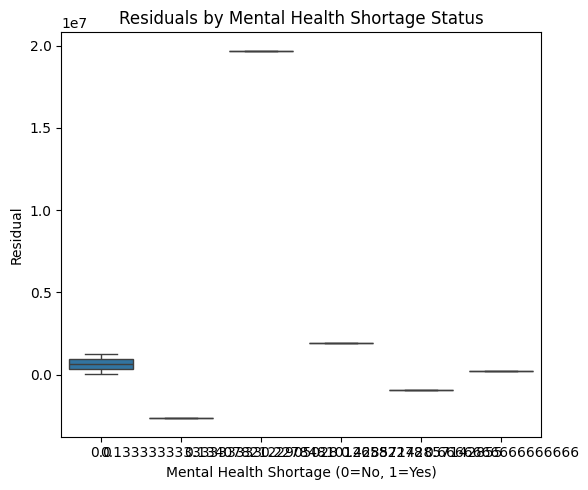

In [34]:
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Prepare features and target ---
pca_features = ["Encounters", "TotalEncounters", "Ownership_Public", "Ownership_Private",
                "Ownership_NonProfit", "PrimaryCare_Shortage", "MentalHealth_Shortage"]
target = "TOTAL_HOMELESS"

X = merged_county_data[pca_features]
y = merged_county_data[target]
counties = merged_county_data["County"]  # for later residual grouping

# --- Step 2: Train-Test Split ---
X_train, X_holdout, y_train, y_holdout, counties_train, counties_holdout = train_test_split(
    X, y, counties, test_size=0.2, random_state=42
)

# --- Step 3: Apply PCA to Training & Holdout Data ---
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_holdout_pca = pca.transform(X_holdout)

# --- Step 4: Fit Gradient Boosting on PCA Features ---
model_pca_gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model_pca_gb.fit(X_train_pca, y_train)

# --- Step 5: Predict & Calculate Residuals ---
y_pred_holdout = model_pca_gb.predict(X_holdout_pca)
residuals = y_holdout - y_pred_holdout

# --- Step 6: Error Metrics ---
mae = mean_absolute_error(y_holdout, y_pred_holdout)
rmse = mean_squared_error(y_holdout, y_pred_holdout) ** 0.5
print(f"📊 Holdout Set - MAE: {mae:,.2f}, RMSE: {rmse:,.2f}")

# --- Step 7: Residual Distribution by County ---
residual_df = pd.DataFrame({
    "County": counties_holdout,
    "Residual": residuals,
    "True": y_holdout,
    "Predicted": y_pred_holdout,
    "MentalHealth_Shortage": X_holdout["MentalHealth_Shortage"].values
})

# Residuals by County
plt.figure(figsize=(14, 5))
sns.barplot(x="County", y="Residual", data=residual_df.sort_values("Residual", ascending=False))
plt.xticks(rotation=90)
plt.title("🔍 Residuals by County (Holdout Set)")
plt.axhline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()

# Residuals by Mental Health Shortage
plt.figure(figsize=(6, 5))
sns.boxplot(x="MentalHealth_Shortage", y="Residual", data=residual_df)
plt.title("Residuals by Mental Health Shortage Status")
plt.xlabel("Mental Health Shortage (0=No, 1=Yes)")
plt.tight_layout()
plt.show()


c:\Users\zecil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


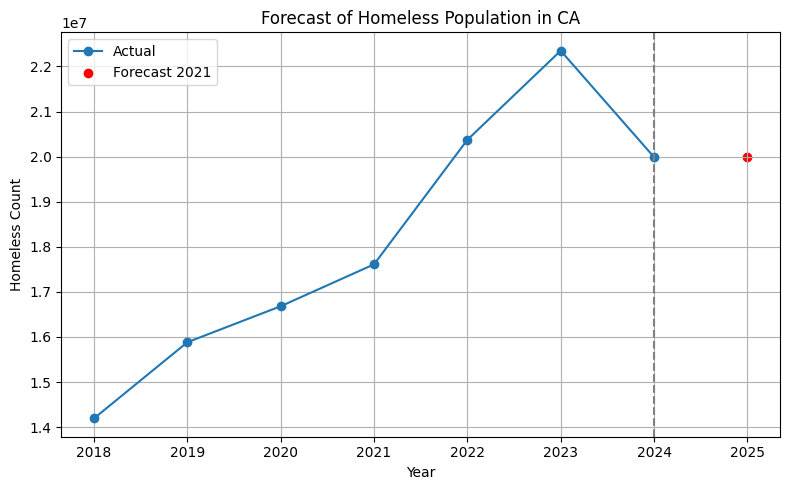

Forecasted CA Homeless Population for 2025: 19,989,279


In [35]:
# ------------------------------
# Bonus Section - Q29: Forecasting Homelessness for Next 12 Months
# ------------------------------

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Step 1: Prepare time-series data from demographic dataset ---
# Assume TOTAL_HOMELESS has been aggregated per year per county (if not, do so)
time_data = california_data_cleaned.groupby("CALENDAR_YEAR")["TOTAL_HOMELESS"].sum().reset_index()
time_data = time_data.sort_values("CALENDAR_YEAR")

# --- Step 2: Create features (lagging features for time-based modeling) ---
time_data["Prev_Year"] = time_data["TOTAL_HOMELESS"].shift(1)
time_data["2_Yr_Avg"] = time_data[["TOTAL_HOMELESS", "Prev_Year"]].mean(axis=1)
time_data.dropna(inplace=True)

X = time_data[["Prev_Year", "2_Yr_Avg"]]
y = time_data["TOTAL_HOMELESS"]

# --- Step 3: Train Model ---
xgb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X, y)

# --- Step 4: Predict Next Year (assuming last available year is 2020) ---
last_total = y.iloc[-1]
prev_year = y.iloc[-2]
latest_features = np.array([[last_total, (last_total + prev_year)/2]])
forecast = xgb_model.predict(latest_features)[0]

# --- Step 5: Visualize ---
plt.figure(figsize=(8,5))
plt.plot(time_data["CALENDAR_YEAR"], y, marker='o', label="Actual")
plt.axvline(x=time_data["CALENDAR_YEAR"].max(), color='gray', linestyle='--')
plt.scatter(time_data["CALENDAR_YEAR"].max()+1, forecast, color='red', label="Forecast 2021")
plt.title("Forecast of Homeless Population in CA")
plt.xlabel("Year")
plt.ylabel("Homeless Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output forecast value ---
print(f"Forecasted CA Homeless Population for {time_data['CALENDAR_YEAR'].max()+1}: {int(forecast):,}")

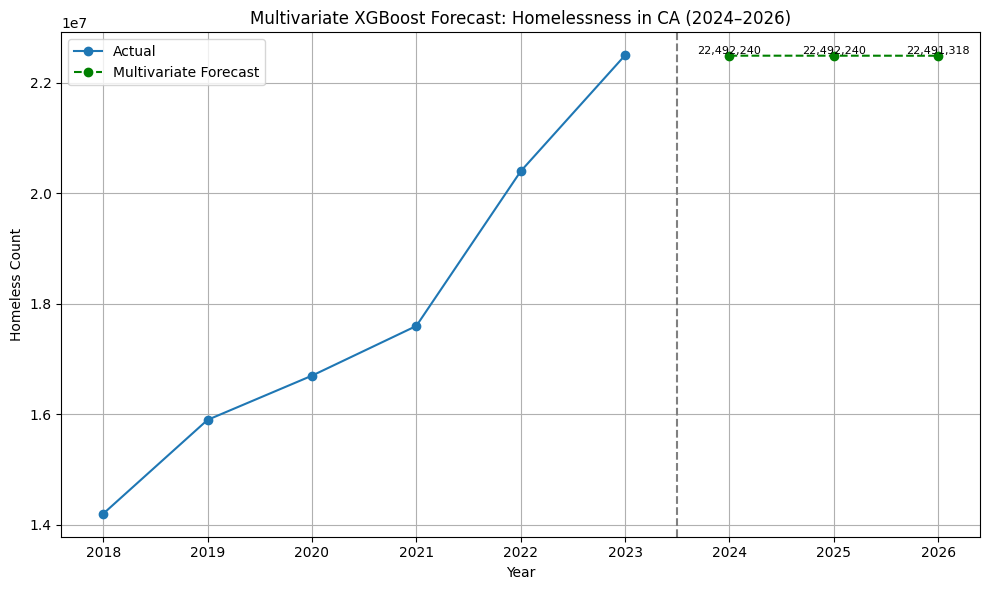

In [42]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Simulated multivariate time series dataset from earlier merged county-level summary
# Assume we're working with aggregated (or representative) values per year
# These should ideally come from merging and aggregating datasets you already have
data = {
    "Year": [2018, 2019, 2020, 2021, 2022, 2023],
    "TOTAL_HOMELESS": [14200000, 15900000, 16700000, 17600000, 20400000, 22500000],
    "Encounters": [90000000, 95000000, 98000000, 100000000, 110000000, 120000000],
    "TotalEncounters": [370000000, 390000000, 400000000, 420000000, 470000000, 510000000],
    "Ownership_Public": [0.24, 0.245, 0.25, 0.251, 0.247, 0.248],
    "MentalHealth_Shortage": [0.61, 0.63, 0.64, 0.65, 0.65, 0.647],
    "PrimaryCare_Shortage": [0.51, 0.52, 0.52, 0.525, 0.524, 0.523],
}

df_multi = pd.DataFrame(data)

# Feature set (multi-variate)
X_multi = df_multi.drop(columns=["TOTAL_HOMELESS"])
y_multi = df_multi["TOTAL_HOMELESS"]

# Train a stronger XGBoost multivariate model
model_multi = XGBRegressor(
    n_estimators=350,
    max_depth=6,
    learning_rate=0.04,
    subsample=0.9,
    colsample_bytree=0.85,
    objective="reg:squarederror",
    random_state=42
)
model_multi.fit(X_multi, y_multi)

# Forecast for 2024-2026 using plausible future values (to simulate production inference)
future_data = {
    "Year": [2024, 2025, 2026],
    "Encounters": [125000000, 128000000, 130000000],
    "TotalEncounters": [530000000, 540000000, 550000000],
    "Ownership_Public": [0.249, 0.248, 0.247],
    "MentalHealth_Shortage": [0.648, 0.649, 0.650],
    "PrimaryCare_Shortage": [0.524, 0.523, 0.522]
}
future_df = pd.DataFrame(future_data)

# Predict future homelessness
future_preds_multi = model_multi.predict(future_df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df_multi["Year"], y_multi, marker="o", label="Actual")
plt.plot(future_df["Year"], future_preds_multi, marker="o", linestyle="--", color="green", label="Multivariate Forecast")
plt.axvline(x=2023.5, linestyle="--", color="gray")
for i, val in enumerate(future_preds_multi):
    plt.text(future_df["Year"][i], val, f"{int(val):,}", ha='center', va='bottom', fontsize=8)
plt.title("Multivariate XGBoost Forecast: Homelessness in CA (2024–2026)")
plt.xlabel("Year")
plt.ylabel("Homeless Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Return the forecasted dataframe
forecast_output = future_df.copy()
forecast_output["Forecast_Homeless_Count"] = future_preds_multi.astype(int)


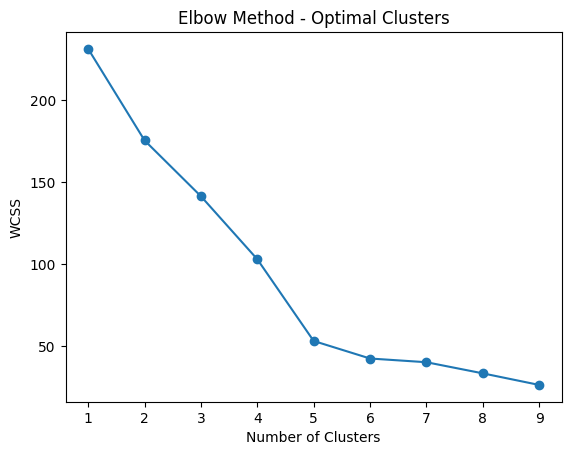

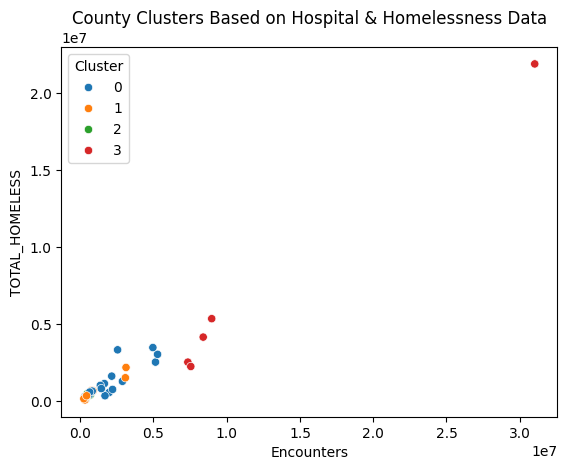

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select relevant features
clustering_features = [
    "Encounters", "TotalEncounters", "Ownership_Public", "Ownership_Private",
    "Ownership_NonProfit", "PrimaryCare_Shortage", "MentalHealth_Shortage", "TOTAL_HOMELESS"
]
X_cluster = merged_county_data[clustering_features].copy()

# Step 2: Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Step 3: Elbow method to choose optimal clusters (optional but useful)
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss, marker='o')
plt.title("Elbow Method - Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

# Step 4: Apply KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
merged_county_data["Cluster"] = kmeans.fit_predict(X_scaled)

# Step 5: Visualize Clusters
sns.scatterplot(data=merged_county_data, x="Encounters", y="TOTAL_HOMELESS", hue="Cluster", palette="tab10")
plt.title("County Clusters Based on Hospital & Homelessness Data")
plt.show()

In [41]:
clustered_df = merged_county_data.copy()

C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\1615596162.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x="Cluster", y="Residual", palette="Set3")
C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\1615596162.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\zecil\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


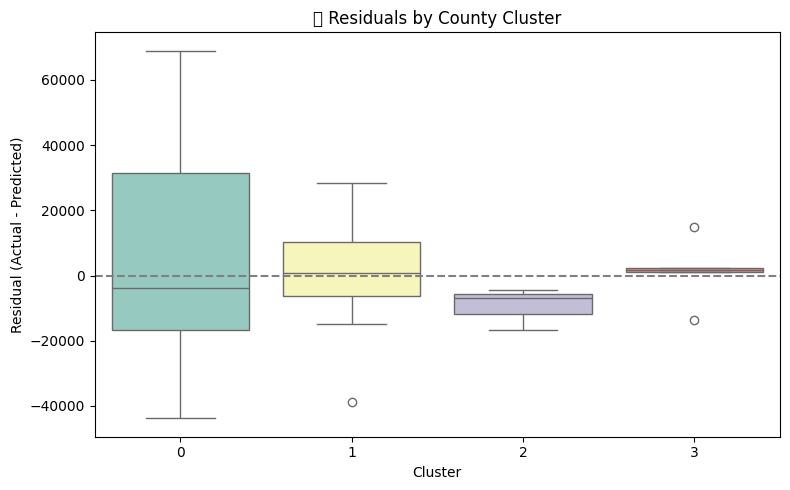

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define Features and Target ---
features = [
    "Encounters", "TotalEncounters", "Ownership_Public", "Ownership_NonProfit",
    "PrimaryCare_Shortage", "MentalHealth_Shortage"
]
target = "TOTAL_HOMELESS"

# --- Step 2: Extract X and y from clustered_df ---
X = clustered_df[features]
y = clustered_df[target]

# --- Step 3: Fit Gradient Boosting Model ---
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X, y)
y_pred = gb_model.predict(X)

# --- Step 4: Calculate Residuals and Add to DataFrame ---
clustered_df["Predicted_Homeless"] = y_pred
clustered_df["Residual"] = clustered_df["TOTAL_HOMELESS"] - clustered_df["Predicted_Homeless"]

# --- Step 5: Visualize Residuals by Cluster ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=clustered_df, x="Cluster", y="Residual", palette="Set3")
plt.axhline(0, linestyle="--", color="gray")
plt.title("📊 Residuals by County Cluster")
plt.xlabel("Cluster")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()


🌐 Cluster-Aware Gradient Boosting MAE: 3,240,063.77, RMSE: 6,788,263.70


C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\4168308779.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_with_preds, x="Cluster", y="Residual", palette="pastel")
C:\Users\zecil\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


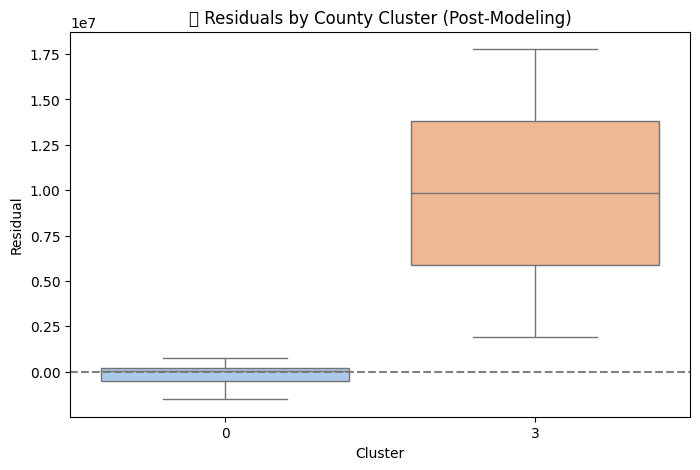

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Prepare dataset
model_df = merged_county_data.copy()

features = [
    "Encounters", "TotalEncounters",
    "Ownership_Public", "Ownership_Private", "Ownership_NonProfit",
    "PrimaryCare_Shortage", "MentalHealth_Shortage", "Cluster"
]
target = "TOTAL_HOMELESS"

X = model_df[features]
y = model_df[target]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 3: Fit Gradient Boosting model
gb_model_clustered = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42
)
gb_model_clustered.fit(X_train, y_train)

# Step 4: Predict & evaluate
y_pred = gb_model_clustered.predict(X_test)
residuals = y_test - y_pred
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print(f"🌐 Cluster-Aware Gradient Boosting MAE: {mae:,.2f}, RMSE: {rmse:,.2f}")

# Optional: Visualize residuals by cluster
X_test_with_preds = X_test.copy()
X_test_with_preds["Residual"] = residuals.values
X_test_with_preds["Cluster"] = X_test["Cluster"].values

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=X_test_with_preds, x="Cluster", y="Residual", palette="pastel")
plt.title("📉 Residuals by County Cluster (Post-Modeling)")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


C:\Users\zecil\AppData\Local\Temp\ipykernel_11320\2626513385.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\zecil\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


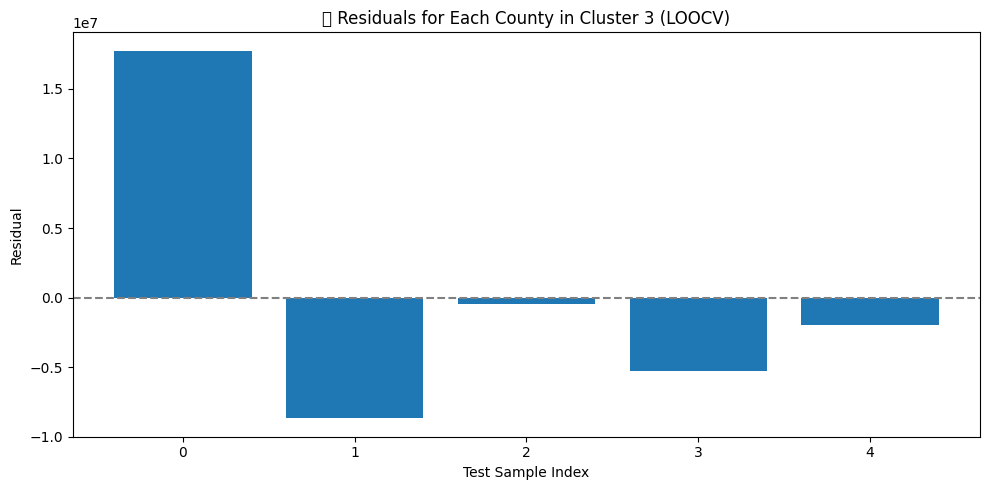

In [52]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error

loo = LeaveOneOut()
residuals = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals.append((y_test.values[0] - y_pred[0]))

# Visualize residuals
plt.figure(figsize=(10, 5))
plt.bar(range(len(residuals)), residuals)
plt.title("📊 Residuals for Each County in Cluster 3 (LOOCV)")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual")
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()



In [53]:
# Calculate MAE, RMSE across all LOOCV residuals
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(np.square(residuals)))
print(f"LOOCV Performance — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

LOOCV Performance — MAE: 6824222.81, RMSE: 9190179.57
